==== DCF Valuation Output ====
Cost of Equity: 9.00%
WACC: 8.41%
PV of Forecasted FCFs: $522,366,032
PV of Terminal Value: $1,863,428,344
Enterprise Value (EV): $2,385,794,375
Equity Value: $2,085,794,375
Implied Share Price: $41.72


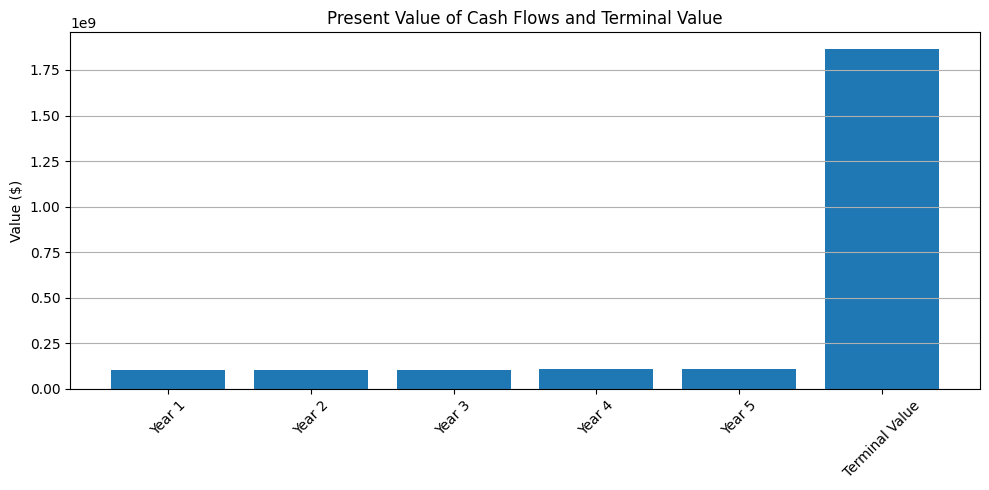

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- INPUTS ---
# These inputs can be later adapted to be read from a config file or CSV
inputs = {
    "risk_free_rate": 0.03,
    "beta": 1.2,
    "market_risk_premium": 0.05,
    "cost_of_debt": 0.055,
    "tax_rate": 0.21,
    "total_debt": 500_000_000,
    "cash_and_equivalents": 200_000_000,
    "shares_outstanding": 50_000_000,
    "FCF_0": 100_000_000,
    "g_exp": 0.10,
    "n": 5,
    "g_term": 0.025,
    "placeholder_share_price": 41.72  # Used for initial equity market value estimation
}

# --- VALIDATIONS ---
assert inputs["g_term"] < inputs["risk_free_rate"] + inputs["beta"] * inputs["market_risk_premium"], \
    "Terminal growth rate must be less than cost of equity"

assert inputs["shares_outstanding"] > 0, "Shares outstanding must be positive"

# --- FUNCTIONS ---

def calculate_cost_of_equity(rf, beta, market_risk_premium):
    return rf + beta * market_risk_premium

def calculate_wacc(cost_of_equity, cost_of_debt, tax_rate, equity_value, debt_value):
    total_value = equity_value + debt_value
    weight_equity = equity_value / total_value
    weight_debt = debt_value / total_value
    return weight_equity * cost_of_equity + weight_debt * cost_of_debt * (1 - tax_rate)

def forecast_fcfs(FCF_0, g_exp, n):
    return [FCF_0 * (1 + g_exp) ** t for t in range(1, n + 1)]

def calculate_terminal_value(FCF_n, g_term, WACC):
    return FCF_n * (1 + g_term) / (WACC - g_term)

def discount_cash_flows(cash_flows, WACC):
    return sum([cf / (1 + WACC) ** (t + 1) for t, cf in enumerate(cash_flows)])

def discount_terminal_value(TV, WACC, n):
    return TV / (1 + WACC) ** n

# --- MAIN CALCULATION ---

# Step 1: Calculate cost of equity
cost_of_equity = calculate_cost_of_equity(
    inputs["risk_free_rate"],
    inputs["beta"],
    inputs["market_risk_premium"]
)

# Step 2: Estimate market value of equity using placeholder price
market_value_equity = inputs["shares_outstanding"] * inputs["placeholder_share_price"]

# Step 3: Calculate net debt
net_debt = inputs["total_debt"] - inputs["cash_and_equivalents"]
net_debt = max(net_debt, 0)  # Ensure non-negative debt

# Step 4: Compute WACC
WACC = calculate_wacc(
    cost_of_equity,
    inputs["cost_of_debt"],
    inputs["tax_rate"],
    market_value_equity,
    net_debt
)

# Step 5: Forecast FCFs and compute terminal value
fcf_list = forecast_fcfs(inputs["FCF_0"], inputs["g_exp"], inputs["n"])
FCF_n = fcf_list[-1]
TV = calculate_terminal_value(FCF_n, inputs["g_term"], WACC)

# Step 6: Discount FCFs and terminal value
PV_FCF = discount_cash_flows(fcf_list, WACC)
PV_TV = discount_terminal_value(TV, WACC, inputs["n"])

# Step 7: Calculate Enterprise and Equity Value
EV = PV_FCF + PV_TV
equity_value = EV - net_debt
share_price = equity_value / inputs["shares_outstanding"]

# --- OUTPUT ---

print("==== DCF Valuation Output ====")
print(f"Cost of Equity: {cost_of_equity:.2%}")
print(f"WACC: {WACC:.2%}")
print(f"PV of Forecasted FCFs: ${PV_FCF:,.0f}")
print(f"PV of Terminal Value: ${PV_TV:,.0f}")
print(f"Enterprise Value (EV): ${EV:,.0f}")
print(f"Equity Value: ${equity_value:,.0f}")
print(f"Implied Share Price: ${share_price:,.2f}")

# --- OPTIONAL: Visualize Cash Flows and Terminal Value ---
years = [f"Year {i+1}" for i in range(inputs["n"])]
cash_flows_with_tv = fcf_list + [TV]
labels = years + ["Terminal Value"]
discounted_values = [cf / (1 + WACC) ** (i + 1) for i, cf in enumerate(fcf_list)] + [PV_TV]

plt.figure(figsize=(10, 5))
plt.bar(labels, discounted_values)
plt.title("Present Value of Cash Flows and Terminal Value")
plt.ylabel("Value ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


Monte Carlo Share Price Summary:
count    1000.000000
mean       43.897706
std        11.406243
min        19.471956
5%         28.367646
25%        35.720368
50%        42.981699
75%        50.092833
95%        63.663004
max       120.764455
Name: Share Price ($), dtype: float64


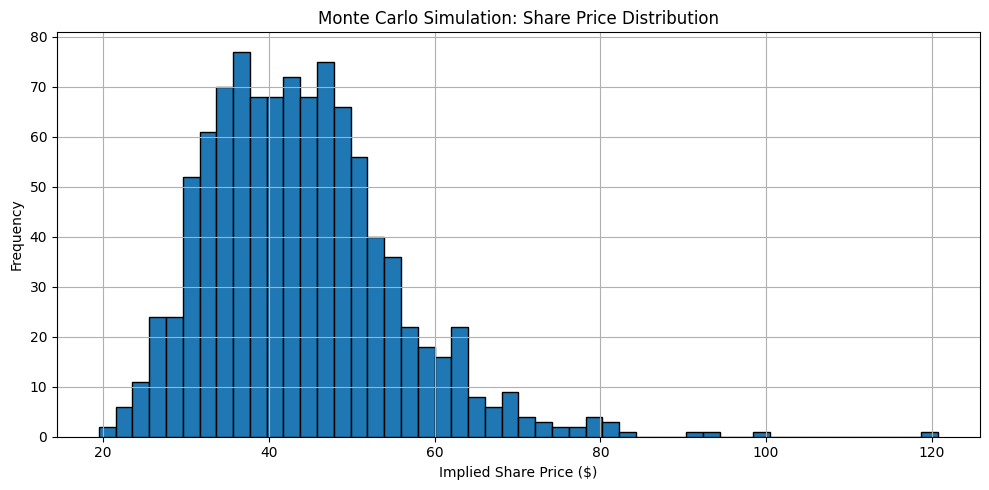

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CUSTOMIZABLE MONTE CARLO CONFIGURATION (Excel-style) ---

num_simulations = 1000

# Define assumptions: mean, std_dev, distribution_type
# Supported distributions: 'normal', 'lognormal', 'uniform', 'triangular'
monte_carlo_config = {
    "beta": {"mean": 1.2, "std": 0.2, "dist": "normal"},
    "g_exp": {"mean": 0.10, "std": 0.03, "dist": "normal"},
    "g_term": {"mean": 0.025, "std": 0.005, "dist": "truncated_normal"},  # GDP constraint
    "cost_of_debt": {"mean": 0.055, "std": 0.01, "dist": "normal"},
    "placeholder_share_price": {"mean": 41.72, "std": 3.0, "dist": "normal"}
}

# --- DISTRIBUTION SAMPLER ---
def sample_distribution(config):
    dist = config["dist"]
    mean = config["mean"]
    std = config["std"]

    if dist == "normal":
        return np.random.normal(mean, std)
    elif dist == "lognormal":
        sigma = np.sqrt(np.log(1 + (std / mean) ** 2))
        mu = np.log(mean) - 0.5 * sigma ** 2
        return np.random.lognormal(mu, sigma)
    elif dist == "uniform":
        return np.random.uniform(mean - std, mean + std)
    elif dist == "triangular":
        return np.random.triangular(mean - std, mean, mean + std)
    elif dist == "truncated_normal":
        while True:
            x = np.random.normal(mean, std)
            if x > 0 and x < 0.05:  # assume terminal growth capped at 5%
                return x
    else:
        raise ValueError(f"Unsupported distribution: {dist}")

# --- STORAGE FOR RESULTS ---
results = []

# --- SIMULATION LOOP ---
for _ in range(num_simulations):
    # Sample each input
    beta_sim = sample_distribution(monte_carlo_config["beta"])
    g_exp_sim = sample_distribution(monte_carlo_config["g_exp"])
    g_term_sim = sample_distribution(monte_carlo_config["g_term"])
    cost_of_debt_sim = sample_distribution(monte_carlo_config["cost_of_debt"])
    placeholder_price_sim = sample_distribution(monte_carlo_config["placeholder_share_price"])

    # Sanity checks
    if beta_sim < 0 or g_exp_sim < 0 or placeholder_price_sim <= 0:
        continue

    cost_of_equity_sim = calculate_cost_of_equity(
        inputs["risk_free_rate"], beta_sim, inputs["market_risk_premium"]
    )

    # Enforce g_term < cost_of_equity
    if g_term_sim >= cost_of_equity_sim:
        continue

    market_value_equity_sim = inputs["shares_outstanding"] * placeholder_price_sim
    WACC_sim = calculate_wacc(
        cost_of_equity_sim,
        cost_of_debt_sim,
        inputs["tax_rate"],
        market_value_equity_sim,
        net_debt
    )

    fcf_list_sim = forecast_fcfs(inputs["FCF_0"], g_exp_sim, inputs["n"])
    FCF_n_sim = fcf_list_sim[-1]
    TV_sim = calculate_terminal_value(FCF_n_sim, g_term_sim, WACC_sim)
    PV_FCF_sim = discount_cash_flows(fcf_list_sim, WACC_sim)
    PV_TV_sim = discount_terminal_value(TV_sim, WACC_sim, inputs["n"])

    EV_sim = PV_FCF_sim + PV_TV_sim
    equity_value_sim = EV_sim - net_debt
    share_price_sim = equity_value_sim / inputs["shares_outstanding"]

    results.append({
        "Beta": beta_sim,
        "g_exp": g_exp_sim,
        "g_term": g_term_sim,
        "Cost of Debt": cost_of_debt_sim,
        "WACC": WACC_sim,
        "EV ($B)": EV_sim / 1e9,
        "Equity ($B)": equity_value_sim / 1e9,
        "Share Price ($)": share_price_sim
    })

# --- OUTPUT RESULTS ---

df_results = pd.DataFrame(results)
summary_stats = df_results.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

print("Monte Carlo Share Price Summary:")
print(summary_stats["Share Price ($)"])

# --- PLOT RESULTS ---
plt.figure(figsize=(10, 5))
plt.hist(df_results["Share Price ($)"], bins=50, edgecolor='black')
plt.title("Monte Carlo Simulation: Share Price Distribution")
plt.xlabel("Implied Share Price ($)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()



Single Valuation Results:
Method    EV ($B)  Equity ($B)  Share Price ($)
  WACC 261.714460   211.714460        42.342892
   APV 211.715707   161.715707        32.343141

Monte Carlo Summary:
Method  EV Mean ($B)  EV Median ($B)  EV P5 ($B)  EV P95 ($B)  Price Mean ($)  Price Median ($)  Price P5 ($)  Price P95 ($)
  WACC    263.189054      260.582838  219.829501   315.112999       42.637811         42.116568     33.965900      53.022600
   APV    212.743061      209.802604  179.831138   252.691460       32.548612         31.960521     25.966228      40.538292


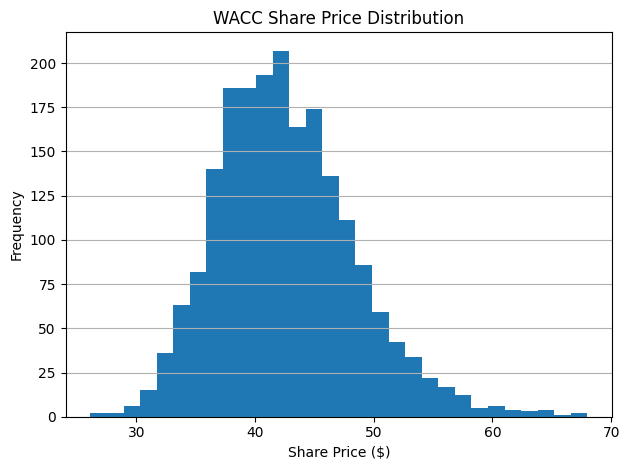

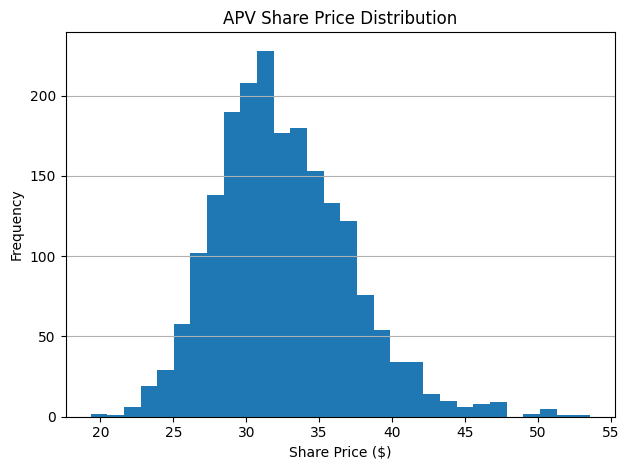


Peer Multiples Summary:
Equal-weighted blended median price: $263.33
  Multiple  Mean Price ($)  Median Price ($)
       P/E           216.0             150.0
 EV/EBITDA           342.0             230.0
EV/Revenue           350.0             410.0


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass, field
from typing import List, Dict, Optional

@dataclass
class ValuationParams:
    # Core inputs
    risk_free_rate: float = 0.02
    market_risk_premium: float = 0.06
    cost_of_debt: float = 0.04
    tax_rate: float = 0.21
    total_debt: float = 100e9
    cash_and_equivalents: float = 50e9
    shares_outstanding: float = 5e9

    # Forecast settings
    n: int = 5
    target_debt_ratio: float = 0.25
    mid_year_discount: bool = True

    # FCF inputs
    fcf_input_mode: str = 'AUTO'               # 'AUTO' or 'LIST'
    FCF_0: float = 10e9
    g_exp: float = 0.08
    g_term: float = 0.02
    fcf_list: List[float] = field(default_factory=lambda: [
        10e9, 10e9 * 1.08, 10e9 * 1.08**2, 10e9 * 1.08**3, 10e9 * 1.08**4
    ])

    # Multiples inputs
    multiples_input: Dict[str, Dict[str, float]] = field(default_factory=lambda: {
        'MSFT':  {'EV/EBITDA': 20.0, 'EV/Revenue': 8.0,  'P/E': 25.0},
        'GOOGL': {'EV/EBITDA': 18.0, 'EV/Revenue': 7.0,  'P/E': 23.0},
        'AMZN':  {'EV/EBITDA': 50.0, 'EV/Revenue': 3.0,  'P/E': 60.0},
    })
    LTM_EBITDA: float = 60e9
    LTM_Revenue: float = 300e9
    LTM_EPS: float = 6.0

def forecast_fcfs(FCF0: float, growth: float, periods: int) -> List[float]:
    """Generate a list of forecast FCFs with constant growth."""
    return [FCF0 * (1 + growth) ** t for t in range(1, periods + 1)]

def discount_cash_flows(cfs: List[float], rate: float, mid_year: bool = False) -> float:
    """Present-value cash flows with annual or mid-year convention."""
    return sum(
        cf / (1 + rate) ** ((i + 1) - (0.5 if mid_year else 0))
        for i, cf in enumerate(cfs)
    )

def calculate_terminal_value(last_cf: float, growth: float, rate: float) -> float:
    """Gordon‐growth terminal value."""
    return last_cf * (1 + growth) / (rate - growth)

def discount_terminal_value(tv: float, rate: float, periods: int, mid_year: bool = False) -> float:
    """Discount terminal value to today."""
    return tv / (1 + rate) ** (periods - (0.5 if mid_year else 0))

def calculate_wacc(ce: float, cd: float, tr: float, dv: float) -> float:
    """Compute WACC given cost of equity, cost of debt, tax rate, and target D/V."""
    return ce * (1 - dv) + cd * (1 - tr) * dv

def calculate_apv(params: ValuationParams,
                  ce: float, cd: float,
                  fcf: List[float],
                  g_term: float) -> float:
    """
    Compute APV:
      - Unlevered value discounted at cost of equity.
      - Tax shields discounted at cost of debt.
    """
    # Unlevered PV of FCFF
    pv_unlev = discount_cash_flows(fcf, ce, params.mid_year_discount)
    tv_unlev = calculate_terminal_value(fcf[-1], g_term, ce)
    pv_tv_unlev = discount_terminal_value(tv_unlev, ce, params.n, params.mid_year_discount)

    # Annual tax shield = Debt × cost_of_debt × tax_rate
    annual_shield = params.total_debt * cd * params.tax_rate
    pv_shields = sum(
        annual_shield / (1 + cd) ** ((t + 1) - (0.5 if params.mid_year_discount else 0))
        for t in range(params.n)
    )

    return pv_unlev + pv_tv_unlev + pv_shields

def prepare_fcfs(params: ValuationParams, g_exp_override: float) -> List[float]:
    """Return forecast FCF list based on mode and (optionally) overridden growth."""
    if params.fcf_input_mode == 'AUTO':
        return forecast_fcfs(params.FCF_0, g_exp_override, params.n)
    else:
        if len(params.fcf_list) != params.n:
            raise ValueError(f"Expected {params.n} FCF items, got {len(params.fcf_list)}")
        return params.fcf_list

def single_ev(params: ValuationParams,
              method: str,
              beta_override: Optional[float] = None,
              cd_override: Optional[float] = None,
              g_exp_override: Optional[float] = None,
              g_term_override: Optional[float] = None,
              dv_override: Optional[float] = None,
              re_override: Optional[float] = None) -> float:
    """
    Compute a single enterprise value under WACC or APV,
    allowing overrides for simulation or custom inputs.
    """
    # Use overrides or defaults
    beta = beta_override if beta_override is not None else 1.1
    cd = cd_override if cd_override is not None else params.cost_of_debt
    g_exp = g_exp_override if g_exp_override is not None else params.g_exp
    g_term = g_term_override if g_term_override is not None else params.g_term
    dv = dv_override if dv_override is not None else params.target_debt_ratio

    # Cost of equity: CAPM or explicit override
    ce = re_override if re_override is not None else (
        params.risk_free_rate + beta * params.market_risk_premium
    )

    # Forecast FCFs
    fcf = prepare_fcfs(params, g_exp)

    if method.upper() == 'WACC':
        wacc = calculate_wacc(ce, cd, params.tax_rate, dv)
        pv_fcf = discount_cash_flows(fcf, wacc, params.mid_year_discount)
        tv = calculate_terminal_value(fcf[-1], g_term, wacc)
        pv_tv = discount_terminal_value(tv, wacc, params.n, params.mid_year_discount)
        return pv_fcf + pv_tv

    elif method.upper() == 'APV':
        return calculate_apv(params, ce, cd, fcf, g_term)

    else:
        raise ValueError(f"Unknown method '{method}'")

def run_single_valuations(params: ValuationParams,
                          methods: List[str]) -> pd.DataFrame:
    """Run a one-off valuation for each method and return a DataFrame."""
    net_debt = params.total_debt - params.cash_and_equivalents
    rows = []
    for m in methods:
        ev = single_ev(params, m)
        equity = ev - net_debt
        share_price = equity / params.shares_outstanding
        rows.append({
            'Method': m,
            'EV ($B)': ev / 1e9,
            'Equity ($B)': equity / 1e9,
            'Share Price ($)': share_price
        })
    return pd.DataFrame(rows)

def run_monte_carlo(params: ValuationParams,
                    methods: List[str],
                    runs: int = 2000,
                    seed: int = 42) -> (pd.DataFrame, Dict[str, np.ndarray]):
    """
    Perform Monte Carlo simulation sampling beta, cost_of_debt,
    growth rates, and D/V. Returns summary DataFrame and raw EV arrays.
    """
    np.random.seed(seed)
    # Draw samples
    betas   = np.maximum(0, np.random.normal(1.1, 1.1 * 0.1, size=runs))
    cds     = np.maximum(0, np.random.normal(params.cost_of_debt, params.cost_of_debt * 0.1, size=runs))
    g_exps  = np.maximum(0, np.random.normal(params.g_exp, params.g_exp * 0.1, size=runs))
    g_terms = np.maximum(0, np.random.normal(params.g_term, params.g_term * 0.1, size=runs))
    dvs     = np.clip(np.random.normal(params.target_debt_ratio, params.target_debt_ratio * 0.1, size=runs), 0, 1)

    net_debt = params.total_debt - params.cash_and_equivalents
    summary_rows = []
    ev_store: Dict[str, np.ndarray] = {}

    for m in methods:
        evs = np.array([
            single_ev(params,
                      m,
                      beta_override=betas[i],
                      cd_override=cds[i],
                      g_exp_override=g_exps[i],
                      g_term_override=g_terms[i],
                      dv_override=dvs[i])
            for i in range(runs)
        ])
        prices = (evs - net_debt) / params.shares_outstanding

        ev_store[m] = evs
        summary_rows.append({
            'Method': m,
            'EV Mean ($B)': evs.mean() / 1e9,
            'EV Median ($B)': np.median(evs) / 1e9,
            'EV P5 ($B)': np.percentile(evs, 5) / 1e9,
            'EV P95 ($B)': np.percentile(evs, 95) / 1e9,
            'Price Mean ($)': prices.mean(),
            'Price Median ($)': np.median(prices),
            'Price P5 ($)': np.percentile(prices, 5),
            'Price P95 ($)': np.percentile(prices, 95),
        })

    return pd.DataFrame(summary_rows), ev_store

def run_multiples_analysis(params: ValuationParams) -> pd.DataFrame:
    """
    Compute implied share prices from peer multiples
    and return a summary DataFrame of means and medians.
    """
    net_debt = params.total_debt - params.cash_and_equivalents
    peer_prices: Dict[str, List[float]] = {'P/E': [], 'EV/EBITDA': [], 'EV/Revenue': []}

    for comp, mults in params.multiples_input.items():
        pe_price     = mults['P/E'] * params.LTM_EPS
        ebitda_price = (mults['EV/EBITDA'] * params.LTM_EBITDA - net_debt) / params.shares_outstanding
        rev_price    = (mults['EV/Revenue'] * params.LTM_Revenue - net_debt) / params.shares_outstanding
        peer_prices['P/E'].append(pe_price)
        peer_prices['EV/EBITDA'].append(ebitda_price)
        peer_prices['EV/Revenue'].append(rev_price)

    summary = []
    for fam, prices in peer_prices.items():
        summary.append({
            'Multiple': fam,
            'Mean Price ($)': np.mean(prices),
            'Median Price ($)': np.median(prices)
        })

    df = pd.DataFrame(summary)
    blended = df['Median Price ($)'].mean()
    print(f"Equal-weighted blended median price: ${blended:.2f}")
    return df

def main():
    params = ValuationParams()
    methods = ['WACC', 'APV']

    # 1. Single valuations
    df_single = run_single_valuations(params, methods)
    print("\nSingle Valuation Results:")
    print(df_single.to_string(index=False))

    # 2. Monte Carlo
    df_mc, ev_store = run_monte_carlo(params, methods, runs=2000, seed=42)
    print("\nMonte Carlo Summary:")
    print(df_mc.to_string(index=False))

    # Plot distributions
    net_debt = params.total_debt - params.cash_and_equivalents
    for m, evs in ev_store.items():
        prices = (evs - net_debt) / params.shares_outstanding
        plt.figure()
        plt.hist(prices, bins=30)
        plt.title(f"{m} Share Price Distribution")
        plt.xlabel("Share Price ($)")
        plt.ylabel("Frequency")
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

    # 3. Multiples analysis
    print("\nPeer Multiples Summary:")
    df_mult = run_multiples_analysis(params)
    print(df_mult.to_string(index=False))

if __name__ == "__main__":
    main()


